# Image inpainting with Pytorch

Artur Magalhães Rodrigues dos Santos
NUSP 10297734

## MAC05921 – Deep Learning
## Task 3



In [1]:

import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Subset

from torchvision import datasets

from constants import BATCH_SIZE, ROOT_FOLDER, DEVICE, LR, GAMMA, STEP_SIZE
from dataset import MaskedCIFAR10
from model import VariationalAutoencoder, train
from utils import plot_image

/home/tuts/anaconda3/envs/transformer-env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/tuts/anaconda3/envs/transformer-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
train_data = MaskedCIFAR10(dataset=datasets.CIFAR10(root=ROOT_FOLDER, 
                                      train=True,
                                      download=True, 
                                      transform=None))

trainset = Subset(train_data, list(range(0, len(train_data), 100)))

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=2)

test_data = MaskedCIFAR10(dataset=datasets.CIFAR10(root=ROOT_FOLDER, 
                                      train=False,
                                      download=True, 
                                      transform=None))

testset = Subset(test_data, list(range(0, len(test_data), 100)))

testloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(f"Dataset Size:\nTrain: {len(trainset)} - Test: {len(testset)}\n")

Dataset Size:
Train: 500 - Test: 100



In [5]:
dataiter = iter(trainloader)
masked_images, images, masks  = next(dataiter)

print(f"Masked images shape = {masked_images.shape}")
print(f"Images shape = {images.shape}")
print(f"Masks shape = {masks.shape}")

Masked images shape = torch.Size([4, 32, 32, 3])
Images shape = torch.Size([4, 32, 32, 3])
Masks shape = torch.Size([4, 15, 15, 3])


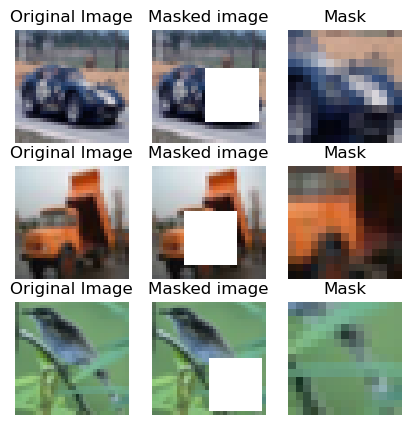

In [6]:
plot_image(trainset)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
from torch.utils.data import DataLoader


from constants import EPOCHS, MODEL_PATH, DEVICE


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, channels=3):
        super(VariationalEncoder, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4),
            nn.BatchNorm2d(32), 
            nn.MaxPool2d(2, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=4),
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.mean = nn.Linear(3872, latent_dims)
        self.var = nn.Linear(3872, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.permute(x, (0, 3, 1, 2))
        print(f"Encoder Input shape = {x.shape}")
        x = self.convs(x)
        x = torch.flatten(x, 1)
        print(f"X shape after flattening = {x.shape}")

        mean = self.mean(x)
        var = torch.exp(self.var(x))

        z = mean + var*self.N.sample(mean.shape)
        self.kl = (var**2 + mean**2 - torch.log(var) - 1/2).sum()

        return z


class Decoder(nn.Module):
    def __init__(self, latent_dims, channels=3):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1024)

        self.convs = nn.Sequential(
            nn.ConvTranspose2d(channels, 64, kernel_size=4),
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=4),
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, channels, kernel_size=1)
        )

    def forward(self, x):
        print(f"Decoder Input shape = {x.shape}")
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.convs(x.reshape(-1, 64, 1, 1))
        return torch.sigmoid(x).reshape(-1, 3, 32, 32)
    

def train(model: VariationalAutoencoder,
          optimizer: torch.optim.Optimizer,
          train_loader: DataLoader,
          val_loader: DataLoader,
          epochs=EPOCHS,
          evaluate=False,
          device=DEVICE) -> None:
    """Trains model using criterion and optimizer. Data is loaded from trainloader

    Args:
        model (VariationalAutoencoder): Autoencoder model
        optimizer (torch.optim.Optimizer): optimizer
        trainloader (DataLoader): dataloader to train the model
        epochs (int, optional): number of epochs to train the model. Defaults to 20.
        evaluate (bool, optional): whether to evaluate the model. Defaults to False.
        device (str, optional): device to train the model. Defaults to 'cuda'.
    
    Returns:
        None. Saves model weights to MODEL_PATH.
    """
    train_avg_losses, val_avg_losses = list(), list()
    print("Starting training stage...")
    for e in range(1, epochs+1):
        model.train()

        # train step
        print(f"Epoch {e}...")
        train_avg_loss = 0
        for i, data in enumerate(train_loader, 0):
            inputs, imgs, _ = data
            inputs = inputs.to(device, dtype=torch.float32)
            imgs = imgs.to(device, dtype=torch.float32)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = F.mse_loss(outputs, imgs) + model.encoder.kl
            train_avg_loss += loss.detach().item()

            loss.backward()
            optimizer.step()

            if i % 2 == 0:
                print(f'[Epoch={e+1}, Iteration={i+1}] train loss: {loss.item():.3f}')
        
        train_avg_loss /= i
        
        # eval step
        if evaluate:
            print("Starting evaluation stage...")
            model.eval()
            eval_avg_loss = 0
            with torch.no_grad():
                for i, data in enumerate(val_loader, 0):
                    inputs, labels = data
                    inputs = inputs.to(device, dtype=torch.float32)
                    labels = labels.to(device, dtype=torch.float32)

                    outputs = model(inputs)
                    loss = F.mse_loss(outputs, imgs) + model.encoder.kl
                    eval_avg_loss += loss.detach().item()

                    if i % 2 == 0:
                        print(f'[Epoch={e+1}, Iteration={i+1}] test loss: {loss.item():.3f}')

            eval_avg_loss /= i

        train_avg_losses.append(train_avg_loss)
        val_avg_losses.append(eval_avg_loss)

    torch.save(model.state_dict(), MODEL_PATH)
    print(f'[Epoch={e+1}] model saved')

    return train_avg_losses, val_avg_losses

In [31]:
model = VariationalAutoencoder(latent_dims=10).to(DEVICE)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [32]:
model

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (convs): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (mean): Linear(in_features=3872, out_features=10, bias=True)
    (var): Linear(in_features=3872, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=10, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=1024, bias=True)
    (convs): Sequential(
      (0): ConvTranspose2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(64, e

In [33]:
train(model, optimizer, trainloader, testloader)

Starting training stage...
Epoch 1...
Encoder Input shape = torch.Size([4, 3, 32, 32])
X shape after flattening = torch.Size([4, 3872])
Decoder Input shape = torch.Size([4, 10])


RuntimeError: Given transposed=1, weight of size [3, 64, 4, 4], expected input[64, 64, 1, 1] to have 3 channels, but got 64 channels instead